# 考虑将每一个项目（论文）表示为一个向量，考虑不同的feature对聚类结果对影响，消除时间对影响，比如发表越早的文章相应的star数，fork数等会多一些，那么考虑其增长速率：star/time

# 供选择的feature有，paper方面，被引用数，paper中图片的数量，paper发表的时间，paper的作者，摘要，发表在什么地方，paper topic



# github方面的可选择的feature有star, fork, watch, readme_size, time, code_frame, latest_issue_updated_time, open_issues_count, repo_size


# <font color=#0099ff face="黑体">Step 1：</font>处理已经爬好的数据

# <font color=#0099ff face="黑体">Step 2：</font>构建数据集，特征向量定义为

# $(repo\_size,achieve,frame\_feature,subscribe\_count÷t,img\_num,repo\_kept\_time,readme\_size,open\_issues\_count÷t,forks\_count÷t,star\_counts÷t,cite\_number÷t)$

# <font color=#0099ff face="黑体">Step 3：</font>使用KMeans聚类

# <font color=#0099ff face="黑体">Step 4：</font>使用PCA降维

In [85]:
import pandas as pd
df1 = pd.read_json('../lastdata_ss_0816.json')
df1 = df1.sort_index(ascending=False).drop_duplicates("title")
df1.reset_index(drop=True, inplace=True)

df4 = pd.read_json('../lastdata_pwc_with_paper_title_0816.json')
df4

,frame,paper_abstract,paper_title,paper_url_abs,paper_url_pdf,repo_url,star_number,task
0,[tf],We present a method for training a regress...,Unsupervised Training for 3D Morphable Model R...,https://arxiv.org/abs/1806.06098v1,https://arxiv.org/pdf/1806.06098v1.pdf,[https://github.com/google/tf_mesh_renderer],[267],[3d face reconstruction]
1,[],We introduce a new inference task - Visual...,Visual Entailment Task for Visually-Grounded L...,https://arxiv.org/abs/1811.10582v2,https://arxiv.org/pdf/1811.10582v2.pdf,[https://github.com/necla-ml/SNLI-VE],[27],"[natural language inference, question answerin..."
2,[torch],Long Short-Term Memory (LSTM) is one of th...,Towards Binary-Valued Gates for Robust LSTM Tr...,https://arxiv.org/abs/1806.02988v1,https://arxiv.org/pdf/1806.02988v1.pdf,[https://github.com/zhuohan123/g2-lstm],[56],[]
3,[torch],The Vision-and-Language Navigation (VLN) t...,Self-Monitoring Navigation Agent via Auxiliary...,https://arxiv.org/abs/1901.03035v1,https://arxiv.org/pdf/1901.03035v1.pdf,[https://github.com/chihyaoma/selfmonitoring-a...,[73],"[natural language visual grounding, vision lan..."
4,[],We review the task of Sentence Pair Scorin...,Sentence Pair Scoring: Towards Unified Framewo...,https://arxiv.org/abs/1603.06127v4,https://arxiv.org/pdf/1603.06127v4.pdf,[https://github.com/brmson/dataset-sts],[476],"[natural language inference, reading comprehen..."
5,[torch],Evaluating open-domain dialogue systems is...,Evaluating Coherence in Dialogue Systems using...,https://arxiv.org/abs/1904.03371v1,https://arxiv.org/pdf/1904.03371v1.pdf,[https://github.com/nouhadziri/DialogEntailment],[20],[]
6,"[torch, tf, tf, tf, tf]",Finding minimum distortion of adversarial ...,Efficient Neural Network Robustness Certificat...,https://arxiv.org/abs/1811.00866v1,https://arxiv.org/pdf/1811.00866v1.pdf,"[https://github.com/huanzhang12/CROWN-IBP, htt...","[16, 10, 10, 10, 8]",[]
7,[tf],Capturing semantic relations between sente...,Grounded Textual Entailment,https://arxiv.org/abs/1806.05645v1,https://arxiv.org/pdf/1806.05645v1.pdf,[https://github.com/claudiogreco/coling18-gte],[1],[natural language inference]
8,[tf],Automated Post-Editing (PE) is the task of...,Automatic Post-Editing of Machine Translation:...,https://www.aclweb.org/anthology/papers/D/D18/...,https://www.aclweb.org/anthology/D18-1341,[https://github.com/trangvu/ape-npi],[1],"[automatic post editing, machine translation]"
9,[],Many practical applications of machine lea...,Meta-Learning Acquisition Functions for Bayesi...,https://arxiv.org/abs/1904.02642v3,https://arxiv.org/pdf/1904.02642v3.pdf,[https://github.com/boschresearch/MetaBO],[1],[meta learning]


In [89]:
df = pd.read_json('../lastdata_git_api_std.json')
df = df.sort_index(ascending=False).drop_duplicates("repo_url")
df.reset_index(drop=True, inplace=True)

df3 = pd.read_json('../git_repo_paper_title.json')
df3 = df3.sort_index(ascending=False).drop_duplicates("repo_url")
df3.reset_index(drop=True, inplace=True)

df = pd.merge(df, df3, on='repo_url').drop_duplicates('paper_title').drop_duplicates('repo_url')
df = pd.merge(df, df4, on='paper_title').drop_duplicates('paper_title')
df.reset_index(drop=True, inplace=True)

df = df.rename(columns={'paper_title':'title'})
df = pd.merge(df, df1, on="title", how='inner')
df.reset_index(drop=True, inplace=True)

df.columns

Index(['forks_count', 'latest_issues_created_at', 'latest_issues_updated_at',
       'open_issues_count', 'readme_size', 'repo_created_at', 'repo_kept_time',
       'repo_name', 'repo_size', 'repo_updated_at', 'repo_url_x',
       'star_counts', 'subscribe_count', 'title', 'frame', 'paper_abstract',
       'paper_url_abs', 'paper_url_pdf', 'repo_url_y', 'star_number', 'task',
       'citations', 'img_num', 'img_src', 'meeting', 'pdf', 'topic', 'venue',
       'year'],
      dtype='object')

# 可以加一个特征表示一个项目有多少个代码实现，值为frame加和

In [194]:
achieve = []
for i in range(len(df)):
    achieve.append(len(df["frame"][i]))
df["achieve"] = achieve

# 再使用一个特征表示其使用的框架,$0-none,1-tf,3-pytorch,5-mxnet$如果有多种实现，就加和一下？
# 比如$4:\{tf,pytorch\},6:\{pytorch, mxnet\},8:\{pytorch, mxnet\},9:\{tf,pytorch, mxnet\}$
# 相同的框架只算一次

In [206]:
dic = {"tf":1, "torch":3, "mxnet":5}
frame_feature = []
for i in range(len(df)):
    if df["frame"][i]:
        value = 0
        for j in df["frame"][i]:
            tmp = set()
            tmp.add(j)
            for frame in tmp:
                value += dic[frame]
        frame_feature.append(value)
    else:
        frame_feature.append(0)
df["frame_feature"] = frame_feature

In [233]:
new_df = df[{'forks_count','star_counts','subscribe_count','open_issues_count','repo_kept_time','repo_size','citations','img_num','readme_size','achieve','frame_feature'}].copy()
tmp = []
for i in range(len(new_df)):
    a = new_df["citations"][i]
    cite = 0
    for j in a:
        cite += int(j.replace(',',''))
    tmp.append(cite)
    #print(cite)
    #if new_df["repo_kept_time"][i] == '1 day, 0:00:00' or new_df["repo_kept_time"][i] == '0:00:00':
    new_df.loc[i, 'repo_kept_time'] = new_df.loc[i, 'repo_kept_time'].replace('1 day, 0:00:00', '1').replace('0:00:00', '1')
new_df["cite_number"] = tmp

In [234]:
new_df = new_df.fillna(0)
new_df = new_df.drop(columns='citations')
data = pd.DataFrame(new_df,dtype=np.float)
import numpy as np
X = data.values

In [238]:
X[np.isnan()] = 0

## 把$issues\_count, star\_count, forks\_count$等都除以$repo\_kept\_time$

In [247]:
for i in range(len(X)):
    X[i][3] /= X[i][5]
    X[i][4] /= X[i][5]
    X[i][7] /= X[i][5]
    X[i][8] /= X[i][5]
    X[i][9] /= X[i][5]
    X[i][10] /= X[i][5]

# <font color=#0099ff face="黑体">Step 3：</font>PCA

In [306]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_2d = pca.transform(X)

# <font color=#0099ff face="黑体">Step 3：</font>使用KMeans聚类

In [268]:
from sklearn.cluster import KMeans # KMeans clustering 
import matplotlib.pyplot as plt
kmeans = KMeans(n_clusters=4)
X_clustered = kmeans.fit_predict(X)
dic1 = {0:0,1:0,2:0,3:0}
for i in range(len(X_clustered)):
    dic1[X_clustered[i]] += 1
dic1

{0: 6588, 1: 1, 2: 1, 3: 69}

In [307]:
from sklearn.cluster import DBSCAN
y_pred = DBSCAN(eps = 1e-100,min_samples = 10).fit_predict(X_2d)

In [308]:
count = 0
for i in y_pred:
    if i == -1:
        count += 1
count

6659

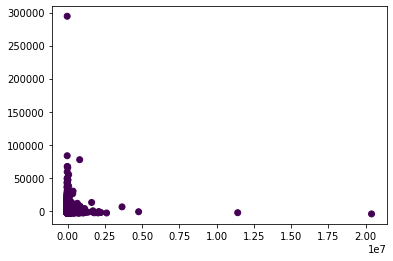

In [309]:
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_pred)
plt.show()

In [ ]:

'''
fig = plt.figure()
ax1 = fig.add_subplot(111)
#设置标题
ax1.set_title('KMeans Clustering (PCA)')
#设置X轴标签
plt.xlabel('First Principal Component')
#设置Y轴标签
plt.ylabel('Second Principal Component')
#plt.xlim(0, 2000000)
#plt.ylim(0, 120000)
#画散点图
ax1.scatter(X_2d[:,0],X_2d[:,1],c = X_clustered, cmap='jet', marker = 'o')
#显示所画的图
plt.show()
'''